In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

plt.style.use('seaborn')
%matplotlib inline
sns.set()

# Curve fitting to soil canister dataset, April 15, 2021

The data here were collected using the soil canisters (and one garden soil insertion).

I am using them to verify that the output of my curve fitting functions match those produced by David's Igor Pro analysis.
The outputs match, except that his RMSE values are exactly 100x my RMSE values.  I therefore plot RMSE * 100 in these plots.

In [2]:
def spec_fit(x, c0, c1, c2, c3, w1, w2, f1):
    '''
    A function for fitting peaks to spectra.
    This fit function was copy-pasted in as text from David's fit function on 5/11/21.
    There are two water peaks (free water and bound water) modeled as gaussian peaks w1 and w2.
    There is the f1 fatty acid peak.
    There is a three-term polynomial function.

    :param x: input data
    :param c0: polynomial term 1
    :param c1: polynomial term 2
    :param c2: polynomial term 3
    :param c3: polynomial term 4
    :param w1: water peak term 1
    :param w2: water peak term 2
    :param f1: fatty acid peak
    :return:
    '''

    f_of_x = c0+c1*(x-1700)+c2*(x-1700)**2+c3*(x-1700)**3 + \
             w1*(0.0751747*np.exp(-(x-1903.82)**2/26.4725**2)+0.225213*np.exp(-(x-1942.21)**2/48.8781**2) +
                 0.005*np.exp(-(x-1779.71)**2/32.1869**2))/7.715 + \
             w2*(0.0280945*np.exp(-(x-1913.6)**2/25.0449**2)+0.103527*np.exp(-(x-1949.5)**2/52.2024**2))/3.07 + \
             f1*(0.31*np.exp(-(x-(1730-24))**2/17**2)+np.exp(-(x-1730)**2/17**2)+0.39 *
                 np.exp(-(x-(1730+31))**2/17**2))/25.484
    return f_of_x

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.

    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra

    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum

    '''
    number = df.shape[0]
    modelparams = np.empty((number, 7), dtype=float)
    modelcovar = np.empty((number, 7, 7), dtype=float)
    modeled_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_fit(wave_array, *modeled)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra


def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values

    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 6]


def create_modelparams_df(modelparams):
    columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    modelparams_df = pd.DataFrame(data=modelparams, columns=columns)
    return modelparams_df


def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.

    Input:  the modelcovar np.array created by model_fit().

    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[6]
    return f_sd_err


def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.

    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]


def get_visible_wavelength_vector(file_path, calibration_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        return wavelength_vector


def get_visible_insertion_absorbance_depth_df(file_path, insertion_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        absorbance_depth = h5_file[f"{insertion_path_str}/derived/absorbance_depth"][:]
        calibration_path_str = insertion_path_str[:17]
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        length = wavelength_vector.shape[0]
        columns = list(np.arange(0, length, 1))
        columns.append('force')
        columns.append('depth')
        dataframe = pd.DataFrame(data=absorbance_depth, columns=columns)
        return dataframe


def create_insertions_date_dataframe(spreadsheet, date_selection):
    df = pd.read_csv(spreadsheet)
    selected_df = df.loc[df['date'] == date_selection]
    return selected_df

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
spreadsheet = 'data/nirone_misc_insertions.csv'
date_selection = '4/15/21'
f1_threshold = 0.06

selected_date_df = create_insertions_date_dataframe(spreadsheet, date_selection)

high_f1_df = pd.DataFrame()
all_values_df = pd.DataFrame()

for index in selected_date_df.index.unique():

    # Determine variables for getting the appropriate data
    file_name = selected_date_df['file_name'][index]
    file = path_name + file_name
    calibration_path = selected_date_df['session'][index] + '/' + selected_date_df['calibration'][index]
    insertion_path = calibration_path + '/' + selected_date_df['insertion'][index]

    # Get the wavelength vector
    waves = get_visible_wavelength_vector(file, calibration_path)

    # Get the absorbance-force-depth dataset and put in DataFrame format
    absorbance_depth_df = get_visible_insertion_absorbance_depth_df(file, insertion_path)
    absorbance_depth_df['file_name'] = file_name
    absorbance_depth_df['insertion'] = insertion_path

    # The model input is only the absorbances part of the dataset
    absorbances = absorbance_depth_df.iloc[:, :-4]

    # Run the model
    modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(absorbances, waves)

    # Calculate the standard deviation of the covariance matrix for the f1 term
    sd_err = extract_f_sd_err(modelcovar)
    absorbance_depth_df['sd_err'] = sd_err

    # RMSE?
    squared_errors = np.square(residual_spectra)
    mse = np.mean(squared_errors, axis=1)
    rmse = np.sqrt(mse)
    absorbance_depth_df['rmse'] = rmse


    # Get the f1 array from the model parameters
    farray = extract_farray(modelparams)
    # absorbance_depth_df['f1_value'] = farray
    absorbance_depth_df[['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']] = modelparams

    # Determine which of the f1 numbers meet the desired threshold
    ins_high_f1s = high_f1_numbers(farray, f1_threshold)

    # Find the spectra that meet the high f1 threshold
    high_spectra = absorbance_depth_df.iloc[ins_high_f1s, :].copy()

    # Append the spectra to the dataframes
    high_f1_df = pd.concat([high_f1_df, high_spectra], ignore_index=True, sort=False)
    all_values_df = pd.concat([all_values_df, absorbance_depth_df], ignore_index=True, sort=False)

In [4]:
ins1 = all_values_df.loc[all_values_df['insertion'] == 'session001/cal003/ins001'].copy()

# Distribution of F1 values across the dataset

In [5]:
all_values_df['f1'].describe()

count    381.000000
mean       0.051111
std        0.179780
min       -0.102336
25%       -0.026399
50%       -0.003656
75%        0.025331
max        0.963515
Name: f1, dtype: float64

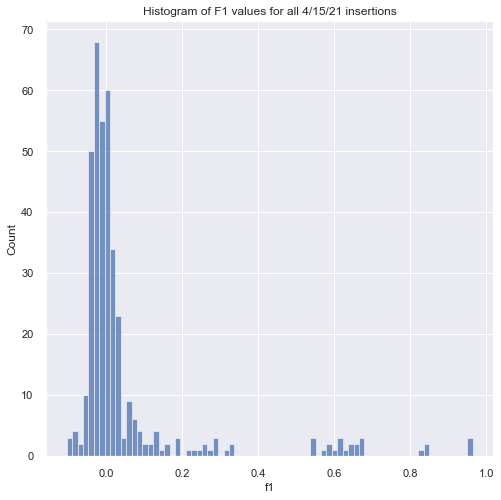

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Histogram of F1 values for all 4/15/21 insertions")
sns.histplot(data=all_values_df, x='f1')
plt.show()
plt.close()

# Histogram plot of F1 values by insertion

The garden soil shows lower F1 values than the lard-spiked soil canister layers.

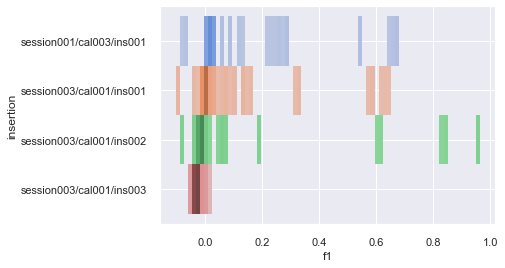

In [7]:
sns.histplot(data=all_values_df, x='f1', y='insertion', hue='insertion', legend=False);

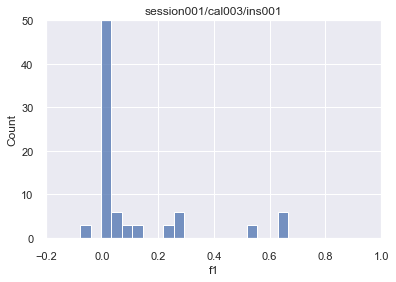

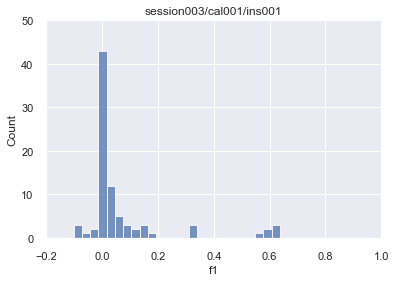

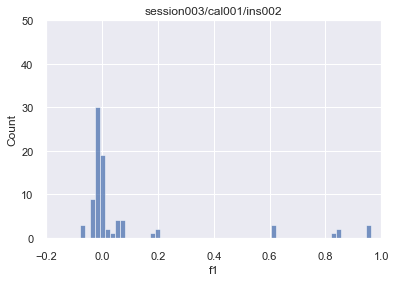

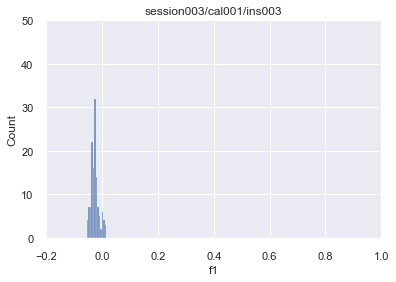

In [8]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots()
    ax.set_title(insertion)
    ax.set_xlim(-0.2, 1.0)
    ax.set_ylim(0, 50)
    sns.histplot(data=plot_df, x='f1')
    plt.show()
    plt.close()

# F1 values by depth for each insertion

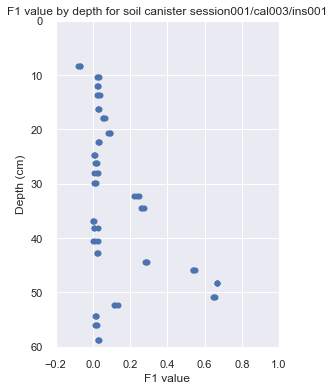

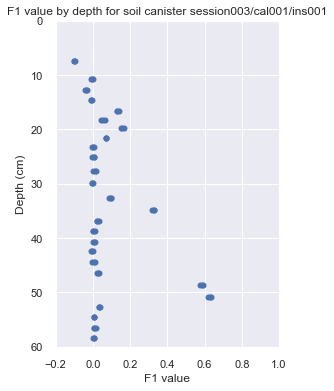

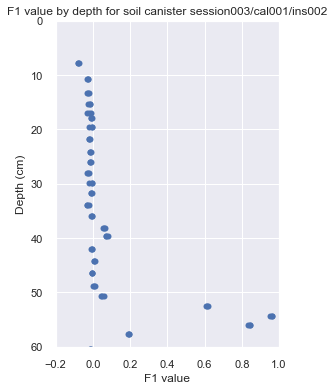

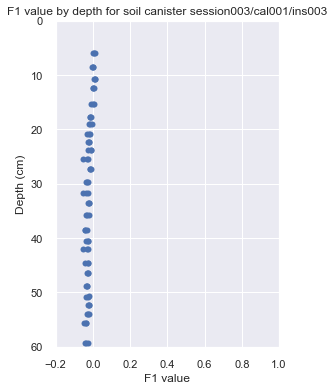

In [9]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(4, 6))
    ax.set_title(f"F1 value by depth for soil canister {insertion}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("F1 value")
    ax.set_ylim(60.0, 0.0)
    ax.set_xlim(-0.2, 1.0)
    ax.plot(plot_df['f1'], plot_df['depth'], 'o')
    plt.show()
    plt.close()

# Distribution of RMSE values across the dataset

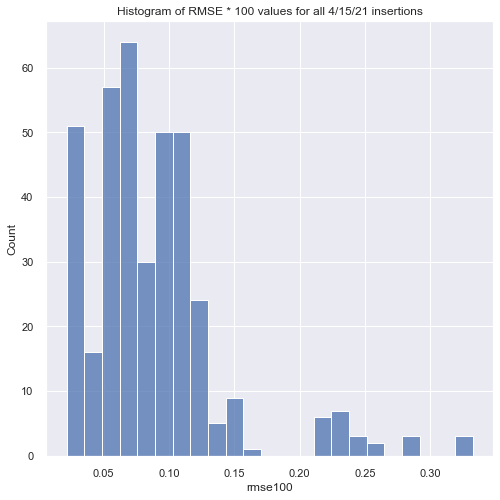

In [10]:
all_values_df['rmse100'] = all_values_df['rmse'] * 100
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Histogram of RMSE * 100 values for all 4/15/21 insertions")
sns.histplot(data=all_values_df, x='rmse100')
plt.show()
plt.close()

In [11]:
all_values_df['rmse100'].describe()

count    381.000000
mean       0.088174
std        0.052913
min        0.021754
25%        0.056663
50%        0.077970
75%        0.107609
max        0.332264
Name: rmse100, dtype: float64

# RMSE values by depth for each insertion

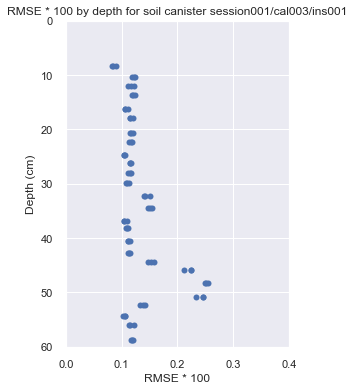

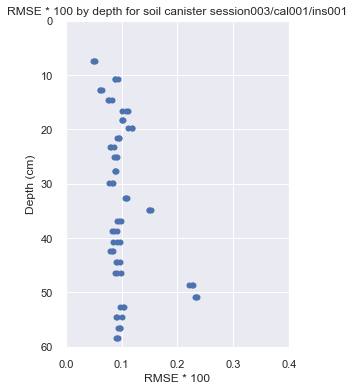

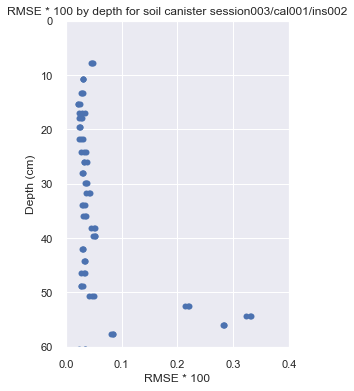

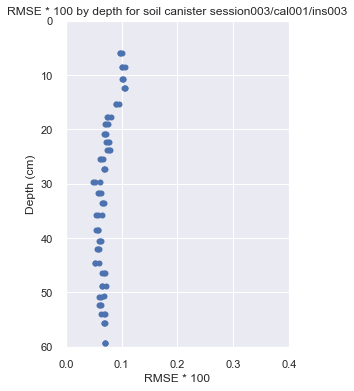

In [12]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(4, 6))
    ax.set_title(f"RMSE * 100 by depth for soil canister {insertion}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("RMSE * 100")
    ax.set_ylim(60.0, 0.0)
    ax.set_xlim(0, 0.4)
    ax.plot(plot_df['rmse'] * 100, plot_df['depth'], 'o')
    plt.show()
    plt.close()

In [13]:
david_df = pd.read_csv('data/David_ins1.csv')

In [14]:
david_df

,Spectrum_,Depth_cm,Force,D_RMSE,D_c0,D_c1,D_c2,D_c3,D_w1,D_w2,D_f1,D_f1_stdev,w1_w2,avg_abs,Comment
0,1,8.3,0.105,0.090,0.580602,0.000082,1.670000e-07,1.440000e-10,0.294,-0.312,-0.079,-14.21,-0.02,0.59,air above soil
1,2,8.3,0.099,0.085,0.580458,0.000082,1.880000e-07,4.470000e-11,0.257,-0.271,-0.070,-13.36,-0.01,0.59,air above soil
2,3,8.3,0.117,0.083,0.580336,0.000083,1.970000e-07,1.000000e-10,0.173,-0.237,-0.067,-13.03,-0.06,0.59,air above soil
3,4,10.4,0.584,0.125,0.496755,0.000065,1.060000e-06,-1.200000e-10,4.310,-0.672,0.034,4.41,3.64,0.53,probe enters soil
4,5,10.4,0.493,0.119,0.497244,0.000063,1.040000e-06,-7.460000e-11,4.248,-0.594,0.025,3.44,3.65,0.53,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,80,60.5,1.727,0.118,0.499096,0.000055,1.020000e-06,-7.100000e-11,4.281,-0.577,0.026,3.61,3.70,0.54,NaN
80,81,60.5,1.752,0.111,0.499262,0.000056,1.000000e-06,2.320000e-12,4.211,-0.536,0.006,0.90,3.67,0.54,NaN
81,82,62.0,1.695,0.125,0.505138,0.000061,1.030000e-06,-1.330000e-10,4.206,-0.533,0.023,2.94,3.67,0.54,NaN
82,83,62.0,1.678,0.117,0.505043,0.000062,1.020000e-06,-1.350000e-10,4.204,-0.536,0.010,1.41,3.67,0.54,NaN


In [15]:
ins1

,0,1,2,3,4,5,6,7,8,9,...,insertion,sd_err,rmse,c0,c1,c2,c3,w1,w2,f1
0,0.571484,0.571043,0.572434,0.572185,0.571476,0.570568,0.571540,0.571012,0.572293,0.572314,...,session001/cal003/ins001,0.000031,0.000903,0.580602,0.000082,1.674346e-07,1.441028e-10,0.294297,-0.311704,-0.079213
1,0.571125,0.572120,0.571985,0.571019,0.571835,0.571821,0.571988,0.572624,0.571846,0.572045,...,session001/cal003/ins001,0.000028,0.000855,0.580458,0.000082,1.878713e-07,4.390826e-11,0.257207,-0.270257,-0.070487
2,0.571125,0.570864,0.572075,0.570751,0.571925,0.571015,0.572256,0.572355,0.571756,0.572672,...,session001/cal003/ins001,0.000026,0.000832,0.580336,0.000083,1.973731e-07,1.005909e-10,0.172703,-0.236647,-0.066898
3,0.513802,0.512260,0.511638,0.511477,0.511087,0.510978,0.510685,0.510623,0.510444,0.510389,...,session001/cal003/ins001,0.000059,0.001247,0.496755,0.000065,1.062064e-06,-1.192010e-10,4.310292,-0.671703,0.033977
4,0.512781,0.512730,0.511404,0.512650,0.511399,0.510433,0.511853,0.509381,0.511300,0.509691,...,session001/cal003/ins001,0.000054,0.001193,0.497244,0.000063,1.040671e-06,-7.450696e-11,4.247628,-0.593954,0.025331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.515851,0.514931,0.514696,0.514217,0.514453,0.513477,0.514513,0.512884,0.513485,0.511089,...,session001/cal003/ins001,0.000053,0.001179,0.499096,0.000055,1.018160e-06,-7.134648e-11,4.280778,-0.577340,0.026293
80,0.514432,0.514616,0.515090,0.513982,0.513590,0.513007,0.514200,0.512493,0.512469,0.512414,...,session001/cal003/ins001,0.000047,0.001109,0.499262,0.000056,1.004287e-06,1.587343e-12,4.210386,-0.535993,0.006137
81,0.521177,0.519048,0.520639,0.519988,0.520069,0.518916,0.519327,0.519500,0.518838,0.518306,...,session001/cal003/ins001,0.000059,0.001247,0.505139,0.000061,1.025200e-06,-1.219980e-10,4.206821,-0.536116,0.022753
82,0.519660,0.520962,0.519364,0.518479,0.520069,0.518916,0.519089,0.518628,0.518046,0.516648,...,session001/cal003/ins001,0.000052,0.001173,0.505044,0.000062,1.023309e-06,-1.338783e-10,4.204528,-0.535963,0.010191


In [16]:
joined = pd.concat([ins1, david_df], axis=1)

In [17]:
joined

,0,1,2,3,4,5,6,7,8,9,...,D_c1,D_c2,D_c3,D_w1,D_w2,D_f1,D_f1_stdev,w1_w2,avg_abs,Comment
0,0.571484,0.571043,0.572434,0.572185,0.571476,0.570568,0.571540,0.571012,0.572293,0.572314,...,0.000082,1.670000e-07,1.440000e-10,0.294,-0.312,-0.079,-14.21,-0.02,0.59,air above soil
1,0.571125,0.572120,0.571985,0.571019,0.571835,0.571821,0.571988,0.572624,0.571846,0.572045,...,0.000082,1.880000e-07,4.470000e-11,0.257,-0.271,-0.070,-13.36,-0.01,0.59,air above soil
2,0.571125,0.570864,0.572075,0.570751,0.571925,0.571015,0.572256,0.572355,0.571756,0.572672,...,0.000083,1.970000e-07,1.000000e-10,0.173,-0.237,-0.067,-13.03,-0.06,0.59,air above soil
3,0.513802,0.512260,0.511638,0.511477,0.511087,0.510978,0.510685,0.510623,0.510444,0.510389,...,0.000065,1.060000e-06,-1.200000e-10,4.310,-0.672,0.034,4.41,3.64,0.53,probe enters soil
4,0.512781,0.512730,0.511404,0.512650,0.511399,0.510433,0.511853,0.509381,0.511300,0.509691,...,0.000063,1.040000e-06,-7.460000e-11,4.248,-0.594,0.025,3.44,3.65,0.53,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.515851,0.514931,0.514696,0.514217,0.514453,0.513477,0.514513,0.512884,0.513485,0.511089,...,0.000055,1.020000e-06,-7.100000e-11,4.281,-0.577,0.026,3.61,3.70,0.54,NaN
80,0.514432,0.514616,0.515090,0.513982,0.513590,0.513007,0.514200,0.512493,0.512469,0.512414,...,0.000056,1.000000e-06,2.320000e-12,4.211,-0.536,0.006,0.90,3.67,0.54,NaN
81,0.521177,0.519048,0.520639,0.519988,0.520069,0.518916,0.519327,0.519500,0.518838,0.518306,...,0.000061,1.030000e-06,-1.330000e-10,4.206,-0.533,0.023,2.94,3.67,0.54,NaN
82,0.519660,0.520962,0.519364,0.518479,0.520069,0.518916,0.519089,0.518628,0.518046,0.516648,...,0.000062,1.020000e-06,-1.350000e-10,4.204,-0.536,0.010,1.41,3.67,0.54,NaN


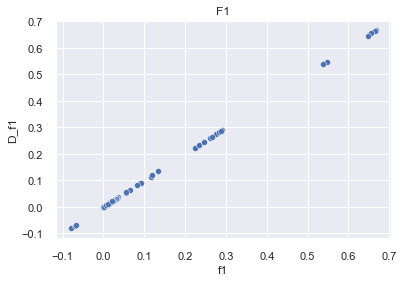

In [18]:
fig, ax = plt.subplots()
ax.set_title("F1")
sns.scatterplot(data = joined, x='f1', y='D_f1');

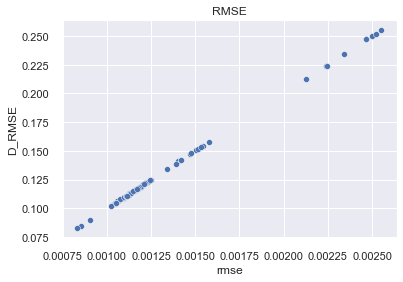

In [19]:
fig, ax = plt.subplots()
ax.set_title("RMSE")
sns.scatterplot(data=joined, x='rmse', y='D_RMSE')
plt.show()
plt.close()

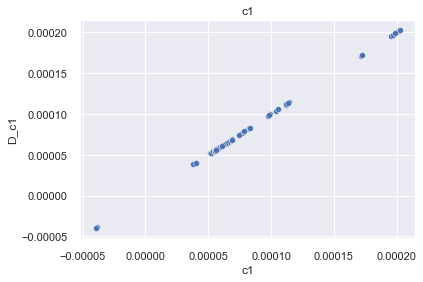

In [20]:
fig, ax = plt.subplots()
ax.set_title("c1")
sns.scatterplot(data=joined, x='c1', y='D_c1')
plt.show()
plt.close()

In [21]:
all_values_df.to_csv('data/soil_canister_output_210512.csv')

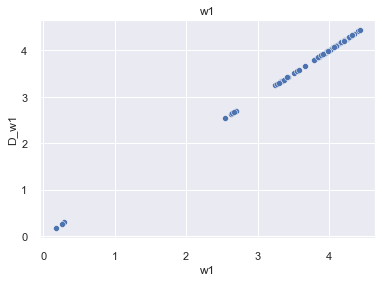

In [22]:
fig, ax = plt.subplots()
ax.set_title("w1")
sns.scatterplot(data=joined, x='w1', y='D_w1')
plt.show()
plt.close()

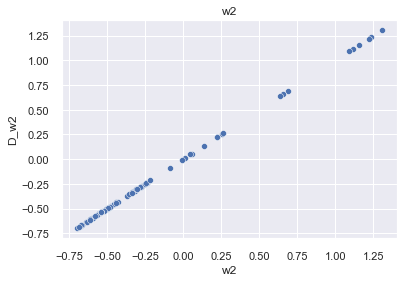

In [23]:
fig, ax = plt.subplots()
ax.set_title("w2")
sns.scatterplot(data=joined, x='w2', y='D_w2')
plt.show()
plt.close()

In [24]:
joined[['w1', 'D_w1']]

,w1,D_w1
0,0.294297,0.294
1,0.257207,0.257
2,0.172703,0.173
3,4.310292,4.310
4,4.247628,4.248
...,...,...
79,4.280778,4.281
80,4.210386,4.211
81,4.206821,4.206
82,4.204528,4.204
